In [2222]:
import torch  
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

"Using Cuda" if torch.cuda.is_available() else "Not using Cuda"

'Using Cuda'

# Machine Learning - Networks

suppose we have data consists of an independent vector an a dependent vector $x_i$ and $y_i$ where $i$ is the $i^{\text{th}}$ value in the data set.

- $x_i$ is the height of the $i^{\text{th}}$ person and $y_i$ is their weight 
- $x_i$ is a picture of handwritten digits and $y_i$ is the digit itself 
- $x_i$ is a CT-Scan of a patient and $y_i$ are the pixels corresponding to tumours. 

Goal of a neural network is to define $f$ that make predictions based on parameters $a$.

$$\hat{y}_i = f(x_i; a)$$

We want to minimize the difference $y_i$ $\hat{y}_i$ and we do this by defining a loss function $L : Y\times Y \mapsto \mathbb{R}$ (where $Y$ is the output space i.e. $y_i, \hat{y}_i \in Y$) to tell us how dis-similar two things. 

A common loss function is RSS $$L_\text{RSS}(y,\hat{y}) = \sum\limits^{n}_{i=1} (y_i - \hat{y}_i)^2$$


In [2223]:
f_original = lambda a,b: a*2 + b + 2
num_points = 32
x = torch.tensor([[i, j] for i in range(num_points) for j in range(num_points)], dtype=torch.float32)
y = torch.tensor([f_original(a,b) for a,b in x], dtype=torch.float32)

Recall our goal is to fit a function $f$ using parameters $a$ to best predict $\hat{y}$ according loss function $L$. Here are our ideas 

1. First multiply each term in $x$ by matrix $M_1 \in \mathbb{R}^{8 \times 2}$ 
    1. So we take our out two inputs and scale them to the first layer with 8 nodes
1. Then multiply each term from the output of $M_1$ by matrix $M_2 \in \mathbb{R}^{1 \times 8}$ 
    1. Take from the last layer with 8 nodes to the output (1 node)

So we have 24 parameters for $a$. 

In [2224]:
layer_size = 32
M1 = nn.Linear(2,layer_size, bias = False) # creates an 8 x 2 matrix 
M1 

Linear(in_features=2, out_features=32, bias=False)

In [2225]:
M2 = nn.Linear(layer_size,1, bias = False) # creates an 1 x 8 matrix 
M2

Linear(in_features=32, out_features=1, bias=False)

In [2226]:
M2(M1(x)).squeeze()  # calling squeeze removes the extra dimension of size 1

tensor([ 0.0000, -0.0207, -0.0414,  ...,  7.7854,  7.7647,  7.7440],
       grad_fn=<SqueezeBackward0>)

Now notice the values are the correct shape for $y$ but not close at all (high loss) so we need to train the matrices $M_1$ and $M_2$ to get them to match better.

We train it by using `nn.Module` to create a training model.

In [2227]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.M1 = nn.Linear(2,layer_size, bias = False)
        self.M2 = nn.Linear(layer_size,1, bias = False)

    def forward(self, x):
        x = self.M1(x)
        x = self.M2(x)
        return x.squeeze()

Lets see the initial parameters

In [2228]:
f = NeuralNet()
for param in f.parameters():
    print(param)

Parameter containing:
tensor([[ 0.3860, -0.2689],
        [-0.5996, -0.6819],
        [-0.2357,  0.4359],
        [ 0.4446,  0.2155],
        [ 0.2000, -0.4751],
        [-0.2086,  0.0858],
        [-0.6171, -0.6433],
        [-0.5364,  0.2193],
        [-0.0897, -0.1248],
        [ 0.4399, -0.4730],
        [-0.4373, -0.1617],
        [ 0.4357,  0.1135],
        [-0.6098,  0.5004],
        [-0.4107,  0.5517],
        [ 0.2588,  0.1854],
        [ 0.5857,  0.2601],
        [-0.6974,  0.2810],
        [ 0.6859, -0.2935],
        [ 0.5178,  0.5724],
        [-0.1666,  0.0010],
        [-0.0916,  0.6254],
        [ 0.2962,  0.5009],
        [-0.6327, -0.2868],
        [-0.5342,  0.1547],
        [-0.2760,  0.2050],
        [ 0.3682, -0.1868],
        [ 0.0832, -0.5212],
        [-0.0815,  0.1144],
        [ 0.5045,  0.2857],
        [ 0.1880,  0.3671],
        [ 0.5531,  0.0664],
        [ 0.6811, -0.4311]], requires_grad=True)
Parameter containing:
tensor([[ 0.0599,  0.0006,  0.1309, -0.

Now lets adjust these weights. We do this by defining $L$.

In [2229]:
yhat = f(x)
yhat # initial predicted values kinda suck 

tensor([  0.0000,  -0.0588,  -0.1175,  ..., -11.6847, -11.7435, -11.8023],
       grad_fn=<SqueezeBackward0>)

Initial loss

In [2230]:
L = nn.MSELoss()
L(yhat, y) # identical to torch.mean((y - yhat).pow(2))

tensor(3514.6697, grad_fn=<MseLossBackward0>)

Note that $L$ depends on $a$. Since our prediction $\hat{y}$ depends on the parameters of the network $a$. In this sense $L=L(a)$. And so our goal is to compute 

$$\dfrac{\partial L}{\partial a_i}$$

for each parameter $a_i$ of the network, we then just adjust each parameter as follows 

$$a_{i+1} = a_i - \gamma \dfrac{\partial L}{\partial a_i}$$

where $\gamma$ is our learning rate 

each iteration of the parameter in this gradient decent is an epoch. So $a_n$ is the $n^\text{th}$ epoch.

Often we just use `SGD` which uses only part of dataset to this gradient decent as then its faster and uses less memory.

In [2231]:
optimizer = torch.optim.SGD(f.parameters(), lr=0.00001)

In [2232]:
num_epochs = 250
losses = []
for i in range(num_epochs):
    optimizer.zero_grad() 
    y_hat = f(x)
    loss = L(y_hat, y)
    loss.backward()
    optimizer.step()
    print(f"Loss for epoch {i} \t {loss}")
    losses.append(loss.item())

Loss for epoch 0 	 3514.669677734375
Loss for epoch 1 	 3075.801025390625
Loss for epoch 2 	 2693.294189453125
Loss for epoch 3 	 2358.756591796875
Loss for epoch 4 	 2065.437744140625
Loss for epoch 5 	 1807.820068359375
Loss for epoch 6 	 1581.3248291015625
Loss for epoch 7 	 1382.100341796875
Loss for epoch 8 	 1206.86474609375
Loss for epoch 9 	 1052.7906494140625
Loss for epoch 10 	 917.4185791015625
Loss for epoch 11 	 798.5925903320312
Loss for epoch 12 	 694.4104614257812
Loss for epoch 13 	 603.1865234375
Loss for epoch 14 	 523.4210815429688
Loss for epoch 15 	 453.77764892578125
Loss for epoch 16 	 393.06390380859375
Loss for epoch 17 	 340.21575927734375
Loss for epoch 18 	 294.2842102050781
Loss for epoch 19 	 254.4236297607422
Loss for epoch 20 	 219.88198852539062
Loss for epoch 21 	 189.99151611328125
Loss for epoch 22 	 164.16046142578125
Loss for epoch 23 	 141.86578369140625
Loss for epoch 24 	 122.64610290527344
Loss for epoch 25 	 106.09552001953125
Loss for epoch 

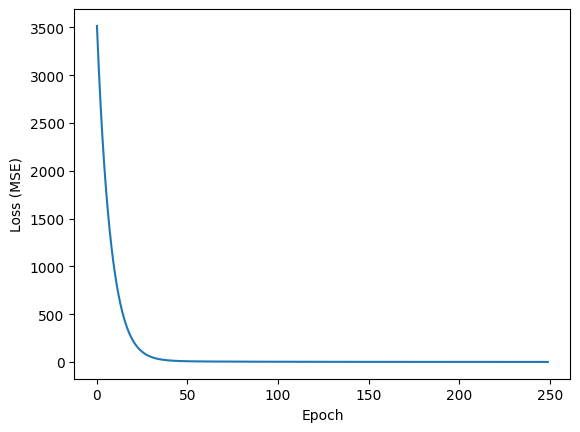

In [2233]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.show()

In [2234]:
yhat = f(x)
yhat # initial predicted values kinda suck 

tensor([ 0.0000,  1.0750,  2.1501,  ..., 94.2810, 95.3560, 96.4311],
       grad_fn=<SqueezeBackward0>)

You can see bellow the original plane we were trying to fit in blue and approximation in red. 

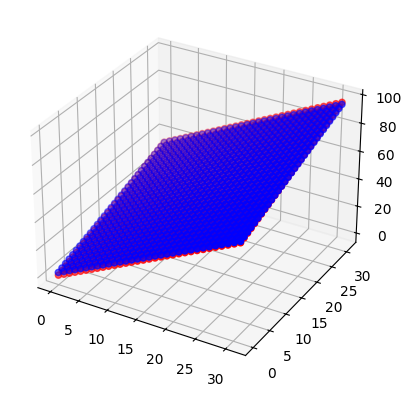

In [2235]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0],x[:,1],y, c='b')
ax.scatter(x[:,0],x[:,1],y_hat.detach(), c='r')
plt.show()